## Historic CMIP


In [46]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import pandas as pd
import seaborn as sns

#niceties
from rich import print


# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing


## Choose region and time period

In [15]:
# name of the catchment
basin_name = "FR000119"

# defining dates for calibration
historical_start_date = "1990-01-01T00:00:00Z"
historical_end_date = "2014-12-31T00:00:00Z"

#Define Catchment Area
shapefile_path = Path.home() / "BEP-Elke" / "book" / "thesis_projects" / "BSc" / "2025_Q4_ElkeSchokking_CEG" / "work in progress" / "ShapefilesFR000119" / "FR000119.shp"


### Set up paths

In [18]:
# Location forcing files in home directory
forcing_path_CMIP = Path.home() / "forcing" / "FR000119"/"CMIP"
forcing_path_CMIP.mkdir(exist_ok=True)

### Catchment

<Axes: >

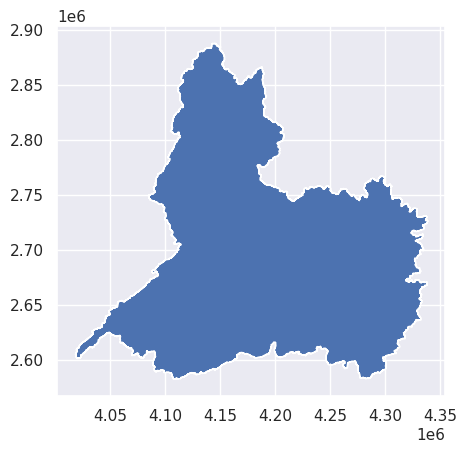

In [47]:
catchment = gpd.read_file(shapefile_path)
catchment = catchment.to_crs(epsg=3035)
catchment["area_km2"] = catchment.geometry.area / 1e6  
basin_area = catchment["area_km2"].sum()
catchment.plot()

## CMIP dataset information

In [21]:
cmip_historical = {
    "dataset": "EC-Earth3",
    "project": "CMIP6",
    "grid": "gr",
    "exp": "historical",
    "ensemble": "r6i1p1f1",
}

## Generate CMIP forcing

In [23]:
# # option one: generate forcing:
# CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset=cmip_dataset,
#    start_time=historical_start_date,
#    end_time=historical_end_date,
#    shape=shapefile_path,
#    directory=forcing_path_CMIP,
# )

In [31]:
#CMIP_forcing.save()

In [29]:
# Option two: load generated data
# Load historical data
historic_location = Path('/home/elke/forcing/FR000119/CMIP/work/diagnostic/script/')
historical = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=historic_location)

In [30]:
print(historical)

LumpedMakkinkForcing(
    start_time='1990-01-01T00:00:00Z',
    end_time='2014-12-31T00:00:00Z',
    directory=PosixPath('/home/elke/forcing/FR000119/CMIP/work/diagnostic/script'),
    shape=PosixPath('/home/elke/forcing/FR000119/CMIP/work/diagnostic/script/FR000119.shp'),
    filenames={
        'pr': 'CMIP6_EC-Earth3_day_historical_r6i1p1f1_pr_gr_1990-2014.nc',
        'tas': 'CMIP6_EC-Earth3_day_historical_r6i1p1f1_tas_gr_1990-2014.nc',
        'rsds': 'CMIP6_EC-Earth3_day_historical_r6i1p1f1_rsds_gr_1990-2014.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

## Setting up the model

### Parameters

In [32]:
#Calibrated parameters, logNSE & EMD
par_0 = [6.3785, 0.9656, 235.0548, 3.8811, 0.2353, 5.3018, 0.0244, 0.0055, 7.4328]
param_names = ['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks', 'FM']

print(list(zip(param_names, np.round(par_0, decimals=3))))

[
    ('Imax', 6.378),
    ('Ce', 0.966),
    ('Sumax', 235.055),
    ('Beta', 3.881),
    ('Pmax', 0.235),
    ('Tlag', 5.302),
    ('Kf', 0.024),
    ('Ks', 0.006),
    ('FM', 7.433)
]

In [33]:
# Starting values for HBV storages (in mm)
# [Si, Su, Sf, Ss, Sp]

s_0 = np.array([0, 100, 0, 5, 0])

### HBV model

In [34]:
model = ewatercycle.models.HBV(forcing=CMIP_forcing)

In [36]:
config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)

In [37]:
model.initialize(config_file)

### Running the model

In [38]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [39]:
model.finalize()

### Process results

In [40]:
model_output = pd.Series(data=Q_m, name="Modelled discharge", index=time)

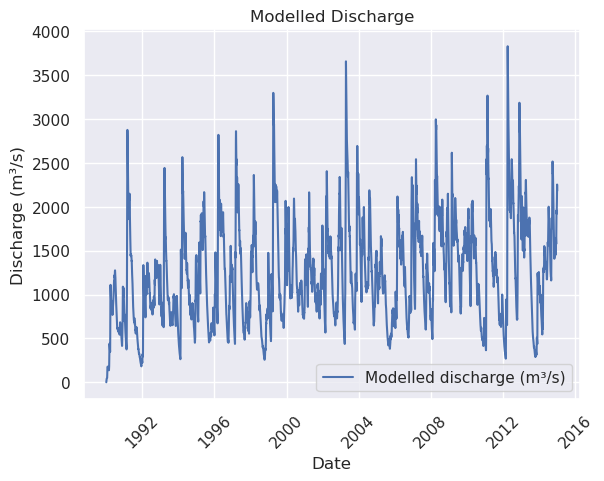

In [48]:
df = pd.DataFrame(model_output)
model_data = df['Modelled discharge'] * basin_area * 1000 / (24 * 60 * 60)
plt.plot(model_data, label='Modelled discharge (m³/s)')

plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Modelled Discharge')
plt.xticks(rotation=45)  # Draai de datums voor betere leesbaarheid
plt.legend()

plt.show()

### Plot against observed discharge

In [50]:
# Slice model data to 2013–2019
model_data_filtered = model_data["2013-01-01":"2019-12-31"]

In [51]:
# Manually parse the file
dates = []
discharges = []

with open("A3550050.csv", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.replace('""', '"').strip().split(',"')
        if len(parts) >= 2:
            date_str = parts[0].strip('"')
            discharge_str = parts[1].strip('"')
            try:
                dates.append(pd.to_datetime(date_str))
                discharges.append(float(discharge_str))
            except ValueError:
                continue

In [52]:
obs_series = pd.Series(discharges, index=dates, name="Observed Discharge (m³/s)")
obs_filtered = obs_series["2013-01-01":"2019-12-31"]

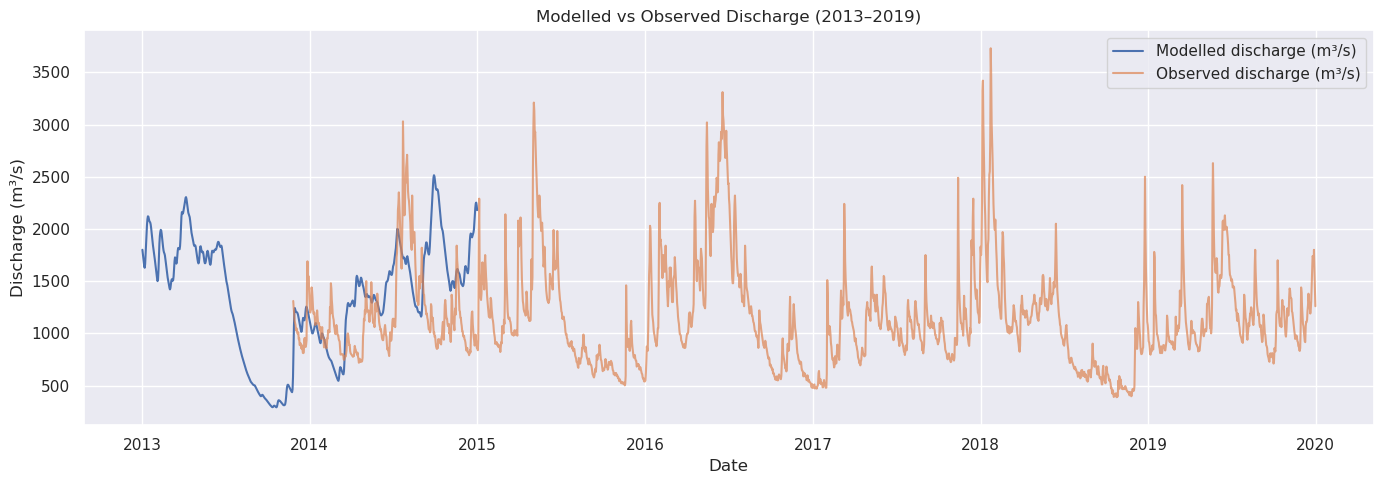

In [53]:
plt.figure(figsize=(14, 5))
plt.plot(model_data_filtered, label='Modelled discharge (m³/s)')
plt.plot(obs_filtered, label='Observed discharge (m³/s)', alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Discharge (m³/s)")
plt.title("Modelled vs Observed Discharge (2013–2019)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

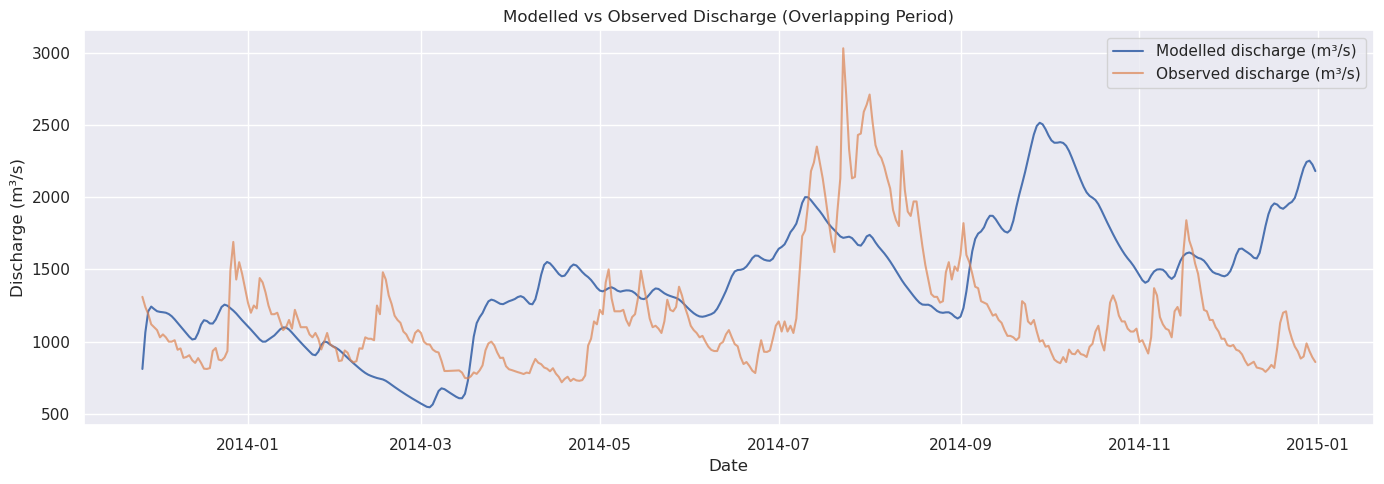

In [61]:

#Normalize timestamps to midnight to align daily data
model_data_filtered.index = model_data_filtered.index.normalize()
obs_filtered.index = obs_filtered.index.normalize()

#Sort indices
model_data_filtered = model_data_filtered.sort_index()
obs_filtered = obs_filtered.sort_index()

#Determine overlapping date range
start_date = max(model_data_filtered.index.min(), obs_filtered.index.min())
end_date = min(model_data_filtered.index.max(), obs_filtered.index.max())

#Slice to overlapping period
model_overlap = model_data_filtered[start_date:end_date]
obs_overlap = obs_filtered[start_date:end_date]

#Align on common dates and drop any missing values
combined = pd.concat([model_overlap, obs_overlap], axis=1).dropna()
model_aligned = combined.iloc[:, 0]
obs_aligned = combined.iloc[:, 1]

#Plot
plt.figure(figsize=(14, 5))
plt.plot(model_aligned, label='Modelled discharge (m³/s)')
plt.plot(obs_aligned, label='Observed discharge (m³/s)', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Discharge (m³/s)")
plt.title("Modelled vs Observed Discharge (Overlapping Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()